**Here I am incorporating both the ACS motion control system for the linear stages, and the PI_GSC2 control system to create an 8-axis motion control system**

In [1]:
import SPiiPlusPython as sp
import pipython

#### Initialize stages and hexapod

In [46]:
# Open COM1 and initialize linear stages
hc = sp.OpenCommSerial(1, 115200)

# Run buffer 1 at the startup level for homing
sp.RunBuffer(hc, 1, "STARTUP", sp.SYNCHRONOUS, True)

In [47]:
# Open COM4 and initialize hexapod
hexapod = pipython.GCS2Device("C-887")
hexapod.ConnectRS232(4, 115200)

# Home hexapod
axes = ['X', 'Y', 'Z', 'U', 'V', 'W']
def zero_hexapod():
    for axis in axes:
        hexapod.MOV(axis, 0)
zero_hexapod()

#### 8-axis motion and position logging

**The purpose of the 8-axis motion and position logging is to store the hexapod position values for specific locations along the XY area of the stages**

At each XY coordinate for the stage, the Z-axis of the hexapod will be moved up until something is "in focus" or "below the surface"

The adjustments that need to be made up and down for each position can correlate to tilt/tip motions throughout the stage movement to create a contour map, ensuring the top of the hexapod is flat to the objective

In [147]:
# Functions for getting absolute positions of stages and hexapod
# Also works when you move it manually with the controller

def getStagePos():
    x_pos = sp.GetTargetPosition(hc, 0, sp.SYNCHRONOUS)
    y_pos = sp.GetTargetPosition(hc, 1, sp.SYNCHRONOUS)
    return(x_pos, y_pos)

def getHexapodPos():
    return(hexapod.qPOS(['X', 'Y', 'Z', 'U', 'V', 'W']))

print(getStagePos())
print(getHexapodPos())

(0.0, 0.0)
OrderedDict({'X': 0.0, 'Y': 0.0, 'Z': 0.0, 'U': -0.0, 'V': 0.0, 'W': -0.0})


In [ ]:
# Logic for creating a contour map
#
# We will start with a simple 2 point contour map along the Y-axis.
# 1. Move to -10mm
# 2. Adjust Z on hexapod to get into "focus"
# 3. Capture position of stage and hexapod {stage: hexapod}
# 4. Set Z to 0
# 5. Move to +10mm
# 6. Adjust Z on hexapod to get into "focus"
# 7. Capture position of stage and hexapod
# 8. Calculate contour map
#


In [209]:
# Contour map
contour_map = {}

In [211]:
# 1. Move Y-stage to -10mm
sp.ExtToPoint(
    hc,
    sp.MotionFlags.ACSC_AMF_VELOCITY,
    sp.Axis.ACSC_AXIS_1,
    -10,
    velocity=15,
    endVelocity=0,
    wait=sp.SYNCHRONOUS,
    failure_check=True
)

In [216]:
# 2. Adjust Z on hexapod (simulating an extreme 3mm drop over 10mm, moving Z up by 3mm to compensate)
hexapod.MOV('Z', 3)

In [217]:
# 3. Capture positions
contour_map[getStagePos()] = getHexapodPos()
contour_map[(0.0, -10.0)]['Z']

3.00000074648

In [218]:
# 4. Set Z to zero
hexapod.MOV('Z', 0)

In [219]:
# 5. Move Y-stage to +10mm
sp.ExtToPoint(
    hc,
    sp.MotionFlags.ACSC_AMF_VELOCITY,
    sp.Axis.ACSC_AXIS_1,
    10,
    velocity=15,
    endVelocity=0,
    wait=sp.SYNCHRONOUS,
    failure_check=True
)

In [220]:
# 6. Adjust Z on hexapod (simulating an extreme 3mm rise over 10mm, moving Z down by 3mm to compensate)
hexapod.MOV('Z', -3)

In [221]:
# 7. Capture position of stage and hexapod
contour_map[getStagePos()] = getHexapodPos()
contour_map[(0.0, 10.0)]['Z']

-2.99999943444

In [223]:
# 8. Calculate contour map (For Z and Y right now)
import numpy as np
from collections import OrderedDict

data=contour_map

# Step 1: Extract Y and Z
points = sorted(data.items(), key=lambda kv: kv[0][1])  # sort by Y
y_vals = np.array([key[1] for key, _ in points])
z_vals = np.array([val['Z'] for _, val in points])

# Step 2: Fit a line Z = aY + b
a, b = np.polyfit(y_vals, z_vals, 1)

# Step 3: Define compensation function
def z_adjustment(y):
    return -(a * y + b)  # This adjustment brings the surface to Z=0

# Calculate the adjustments to be made
for y in np.arange(-10, 10.1, 0.1):
    print(f"Y={y:>6.1f}: Z adjustment = {z_adjustment(y):.6f}")


Y= -10.0: Z adjustment = -3.000001
Y=  -9.9: Z adjustment = -2.970001
Y=  -9.8: Z adjustment = -2.940001
Y=  -9.7: Z adjustment = -2.910001
Y=  -9.6: Z adjustment = -2.880001
Y=  -9.5: Z adjustment = -2.850001
Y=  -9.4: Z adjustment = -2.820001
Y=  -9.3: Z adjustment = -2.790001
Y=  -9.2: Z adjustment = -2.760001
Y=  -9.1: Z adjustment = -2.730001
Y=  -9.0: Z adjustment = -2.700001
Y=  -8.9: Z adjustment = -2.670001
Y=  -8.8: Z adjustment = -2.640001
Y=  -8.7: Z adjustment = -2.610001
Y=  -8.6: Z adjustment = -2.580001
Y=  -8.5: Z adjustment = -2.550001
Y=  -8.4: Z adjustment = -2.520001
Y=  -8.3: Z adjustment = -2.490001
Y=  -8.2: Z adjustment = -2.460001
Y=  -8.1: Z adjustment = -2.430001
Y=  -8.0: Z adjustment = -2.400001
Y=  -7.9: Z adjustment = -2.370001
Y=  -7.8: Z adjustment = -2.340001
Y=  -7.7: Z adjustment = -2.310001
Y=  -7.6: Z adjustment = -2.280001
Y=  -7.5: Z adjustment = -2.250001
Y=  -7.4: Z adjustment = -2.220001
Y=  -7.3: Z adjustment = -2.190001
Y=  -7.2: Z adjustme

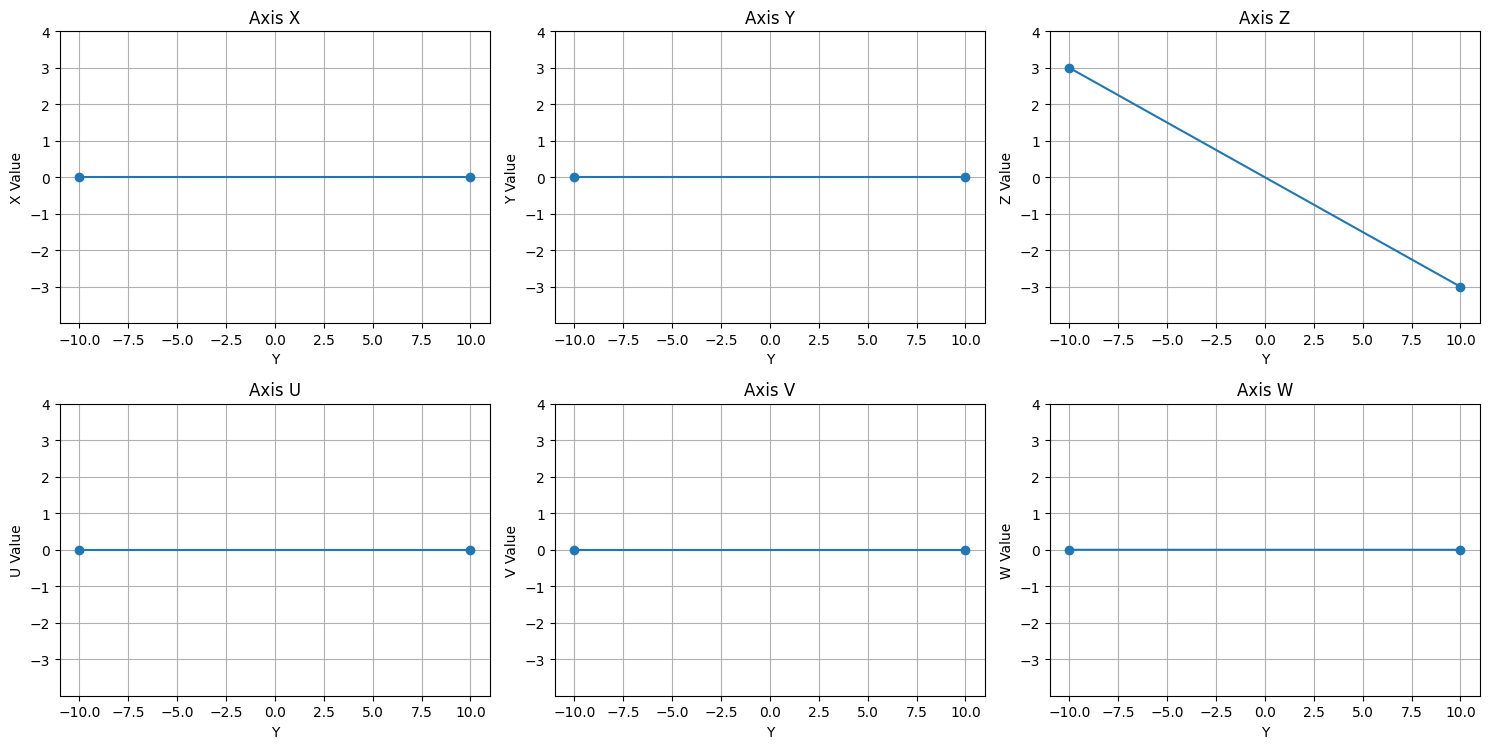

In [238]:
data = contour_map

# Extract coordinate ranges
x_coords = sorted(set(k[0] for k in data))
y_coords = sorted(set(k[1] for k in data))

# Create grids for each axis
axis_grids = {axis: np.full((len(y_coords), len(x_coords)), np.nan) for axis in axes}
for (x, y), pos in data.items():
    i = y_coords.index(y)
    j = x_coords.index(x)
    for axis in axes:
        axis_grids[axis][i, j] = pos[axis]

# Get global y-axis min and max across all axes
global_ymin = min(np.nanmin(axis_grids[axis][:, 0]) for axis in axes) - 1
global_ymax = max(np.nanmax(axis_grids[axis][:, 0]) for axis in axes) + 1

# Create line plots with uniform y-axis scaling
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()

y_vals = np.array(y_coords)

for i, axis in enumerate(axes):
    axis_vals = axis_grids[axis][:, 0]  # Values at X=0
    axs[i].plot(y_vals, axis_vals, marker='o')
    axs[i].set_title(f'Axis {axis}')
    axs[i].set_xlabel('Y')
    axs[i].set_ylabel(f'{axis} Value')
    axs[i].set_ylim(global_ymin, global_ymax)
    axs[i].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Shut down stages and hexapod

In [235]:
# Disable all motors and terminate linear stage connection
sp.DisableAll(hc, sp.SYNCHRONOUS, True)
sp.CloseComm(hc)

In [236]:
# Close connection with hexapod controller
hexapod.CloseConnection()

In [ ]:
#
# We can now create a contour map showing the required adjusted Z values for a simulated change in Y with deviations in Z. 
# 
# Point to point movements don't seem to work very well for smooth operation where the hexapod and stage are moving at 
# the same time. 
# 
# It's probably best to set velocities and durations:
# Stages: sp.MotionFlags.ACSC_AMF_VELOCITY
# Hexapod: BOOL PI_VLS (int ID, double dSystemVelocity) (DOESNT WORK YET, NEED TO FIGURE THAT OUT)
# 
# Then we can trigger them both at the same time and have them move at proportional rates, nice and smooth.
# This same functionality will loop in with the AWG for printing.
#
# TO DO: 
# 1. Figure out how to change hexapod velocities
# 2. Test it by having the hexapod and stage move in opposite directions (+y, -y) while it holds a laser pointer, 
#    See if the laser pointer moves. Ideally it should stay in the same spot. If not, it can give some insights 
#    into better control mechanisms.
#